# UMAP on the PBMC dataset of Zheng

In [1]:

%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import umap
from firelight.visualizers.colorization import get_distinct_colors
from matplotlib.colors import ListedColormap
import pickle
import matplotlib.lines as mlines
import matplotlib
from umap.my_plot import plot_all_losses, hists_from_graph_embd
from umap.my_utils import filter_graph

env: CUDA_VISIBLE_DEVICES=2


In [2]:
dir_path = "../data/zheng_pbmc"
fig_path = "../figures"
seed = 0


In [3]:
# load the data
pca50 = pd.read_csv(os.path.join(dir_path,
                              "pbmc_qc_final.txt"),
                     sep='\t',
                     header=None)
pca50.shape

(68551, 50)

In [4]:
cell_types = pd.read_csv(os.path.join(dir_path,
                              "pbmc_qc_final_labels.txt"),
                   sep=',',
                   header=None).to_numpy().flatten()
np.unique(cell_types)

# rename cell types by stripping "CD..." prefixes if possible
for i in range(len(cell_types)):
    words = cell_types[i].split(" ")
    if words[0].startswith("CD") and not len(words) == 1:
        words = words[1:]
    cell_types[i] = " ".join(words)

labels = np.zeros(len(cell_types)).astype(int)
name_to_label = {}
for i, phase in enumerate(np.unique(cell_types)):
    name_to_label[phase] = i
    labels[cell_types==phase] = i
np.random.seed(seed)
colors = get_distinct_colors(len(name_to_label))
cmap = ListedColormap(colors)
np.random.shuffle(colors)


In [5]:
try:
    with open(os.path.join(dir_path, f"umapperns_after_seed_{seed}.pkl"), "rb") as file:
        umapperns_after = pickle.load(file)
        embd_after = umapperns_after.embedding_
except FileNotFoundError:
    umapperns_after = umap.UMAP(metric="cosine",
                                  n_neighbors=30,
                                  n_epochs=750,
                                  log_losses="after",
                                  random_state=seed,
                                  verbose=True)
    embd_after = umapperns_after.fit_transform(pca50)
    with open(os.path.join(dir_path, f"umapperns_after_seed_{seed}.pkl"), "wb") as file:
        pickle.dump(umapperns_after, file, pickle.HIGHEST_PROTOCOL)


Wed Oct 27 13:42:51 2021 Building and compiling search function


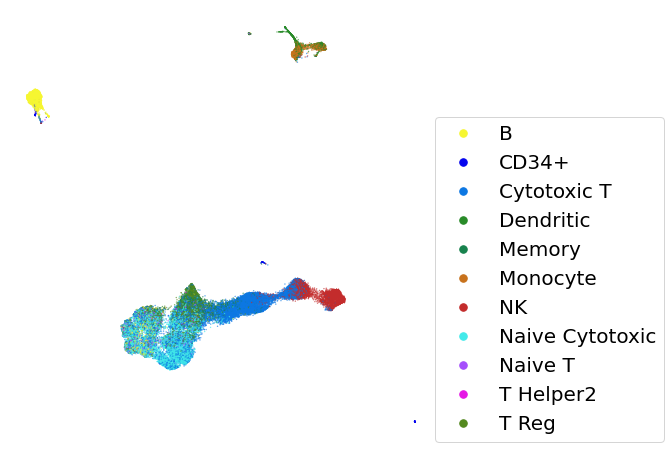

In [6]:
plt.figure(figsize=(8,8))
scatter = plt.scatter(-embd_after[:,1],
                      -embd_after[:,0],
                      c=labels,
                      s=0.1,
                      alpha=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")

# dummy dots for legend
dots = []
for i in range(len(np.unique(cell_types))):
    dot = mlines.Line2D([], [], color=colors[i], marker='.', linestyle="none",
                          markersize=15, label=np.unique(cell_types)[i])
    dots.append(dot)
plt.legend(handles=dots, prop={'size': 20}, loc=(1,0))

plt.savefig(os.path.join(fig_path, f"pbmc_after_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)

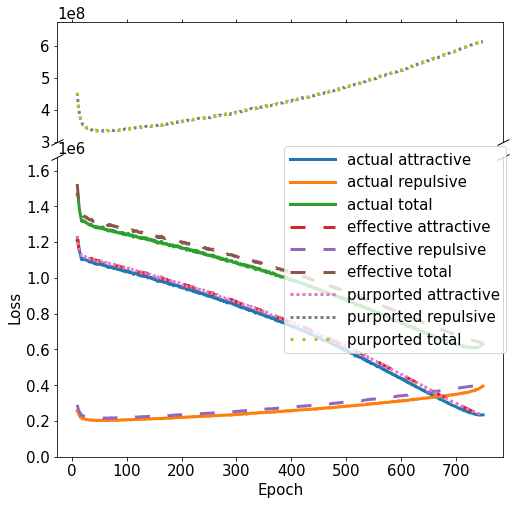

In [7]:
start=10 # omit early epochs where UMAP's sampling approximation is poor
matplotlib.rcParams.update({'font.size': 15})
fig_losses_after = plot_all_losses(umapperns_after.aux_data,start=start)
fig_losses_after.savefig(os.path.join(fig_path, f"pbmc_after_losses_{start}_seed_{seed}.png"),
                         bbox_inches = 'tight',
                         pad_inches = 0,
                         dpi=300)

In [8]:
alpha=0.5
min_dist = 0.1
spread = 1.0
a, b= umap.umap_.find_ab_params(spread=spread, min_dist=min_dist)

In [9]:
fil_graph = filter_graph(umapperns_after.graph_, umapperns_after.n_epochs).tocoo()

In [10]:
hist_high_pbmc, \
hist_high_pos_pbmc, \
hist_target_pbmc, \
hist_target_pos_pbmc, \
hist_low_pbmc, \
hist_low_pos_pbmc, \
bins_pbmc = hists_from_graph_embd(graph=fil_graph,
                                       embedding=embd_after,
                                       a=a,
                                       b=b)

Compiling libKeOpstorch01732b3894 in /net/hcihome/storage/sdamrich/.cache/pykeops-1.4.2-cpython-38-gpu2:
       formula: Max_Reduction(Inv((Var(4,1,2) + (Var(0,1,2) * Powf(Sum(Square((Var(1,2,0) - Var(2,2,1)))), Var(3,1,2))))),1)
       aliases: Var(0,1,2); Var(1,2,0); Var(2,2,1); Var(3,1,2); Var(4,1,2); 
       dtype  : float32
... Done.
Compiling libKeOpstorch8d5aad4690 in /net/hcihome/storage/sdamrich/.cache/pykeops-1.4.2-cpython-38-gpu2:
       formula: Min_Reduction(Inv((Var(4,1,2) + (Var(0,1,2) * Powf(Sum(Square((Var(1,2,0) - Var(2,2,1)))), Var(3,1,2))))),1)
       aliases: Var(0,1,2); Var(1,2,0); Var(2,2,1); Var(3,1,2); Var(4,1,2); 
       dtype  : float32
... Done.
Compiling libKeOpstorchbae831412a in /net/hcihome/storage/sdamrich/.cache/pykeops-1.4.2-cpython-38-gpu2:
       formula: Sum_Reduction(((IntCst(1) - Step((Minus(Inv((Var(4,1,2) + (Var(0,1,2) * Powf(Sum(Square((Var(1,2,0) - Var(2,2,1)))), Var(3,1,2)))))) + Var(5,1,2)))) * Step((Minus(Inv((Var(4,1,2) + (Var(0,1,2) * Po

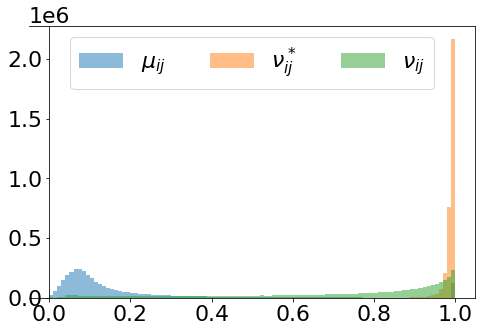

In [11]:
# plot histogram of positive high-dimensional edges
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(8, 5))
plt.hist(bins_pbmc[:-1], bins_pbmc, weights=hist_high_pos_pbmc, alpha=alpha, label=r"$\mu_{ij}$")
plt.hist(bins_pbmc[:-1], bins_pbmc, weights=hist_target_pos_pbmc, alpha=alpha, label=r"$\nu_{ij}^*$")
plt.hist(bins_pbmc[:-1], bins_pbmc, weights=hist_low_pos_pbmc, alpha=alpha, label=r"$\nu_{ij}$")

plt.legend(loc="upper center", ncol=3)
#plt.yscale("symlog", linthresh=1)
plt.gca().spines['left'].set_position("zero")
plt.gca().spines['bottom'].set_position("zero")
#plt.savefig(os.path.join(fig_path, f"pbmc_hist_sims_pos_seed_{seed}.png"),
#            bbox_inches = 'tight',
#            pad_inches = 0,dpi=300)
